In [174]:
%matplotlib inline


# Solving Blackjack with Reinforcement Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [6]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import random
import os

import gymnasium as gym

from blackjack import ControlType, BlackJackAgent
import visualize
from visualize import reward_plot, training_plot, create_grids, create_plots, culmulative_return_calculate, reward_count, Reward_compare_plot


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

In [1]:
Training_Culmulative_Return_ls = []
Training_reward_moving_average_ls = []
Testing_Culmulative_Return_ls = []
Testing_reward_moving_average_ls = []

.. code:: py

  # Other possible environment configurations are:

  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.




## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [177]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [178]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




# Q-Learning

## Parameters Studies for Q-Learning Algorithm

Discount 

100%|██████████| 10000/10000 [00:01<00:00, 5061.33it/s]


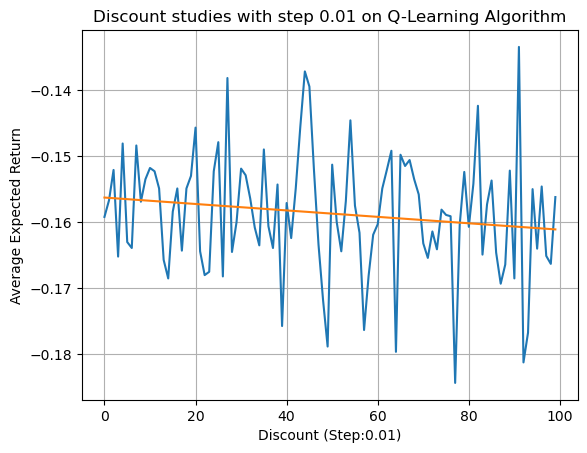

In [179]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4878.58it/s]


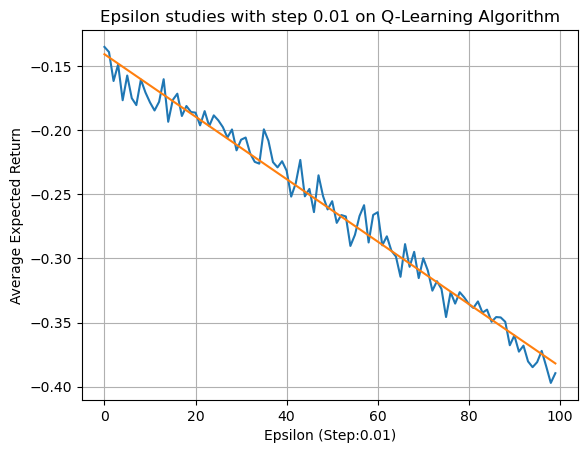

In [180]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

100%|██████████| 10000/10000 [00:02<00:00, 4897.13it/s]


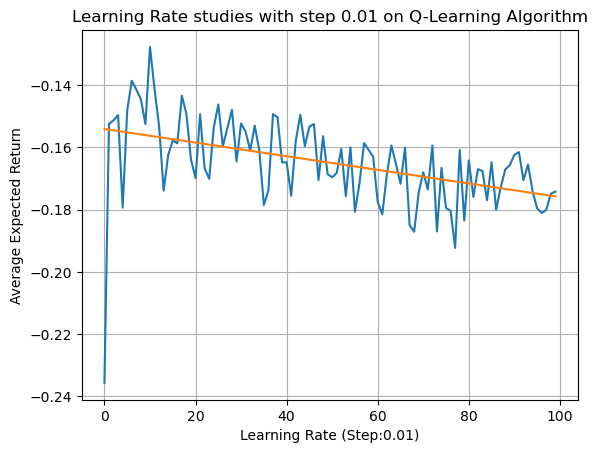

In [8]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,learning_rate_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type = ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [9]:
#Training Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  1%|          | 10826/1000000 [00:02<03:28, 4752.35it/s]

100%|██████████| 1000000/1000000 [03:36<00:00, 4627.21it/s]


Save Agent

In [10]:
#Save Double Q-Learning agent
q_value_file = "q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Q-Learning Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29547 negative:0.65967
Iteration[100000:200000]     positive:0.32727 negative:0.61859
Iteration[200000:300000]     positive:0.35416 negative:0.58277
Iteration[300000:400000]     positive:0.3879 negative:0.54007
Iteration[400000:500000]     positive:0.4169 negative:0.49923
Iteration[500000:600000]     positive:0.43574 negative:0.47759
Iteration[600000:700000]     positive:0.43364 negative:0.47835
Iteration[700000:800000]     positive:0.43114 negative:0.48006
Iteration[800000:900000]     positive:0.4342 negative:0.47699
Iteration[900000:1000000]     positive:0.43016 negative:0.48192

====================== Reward Frequency ======================


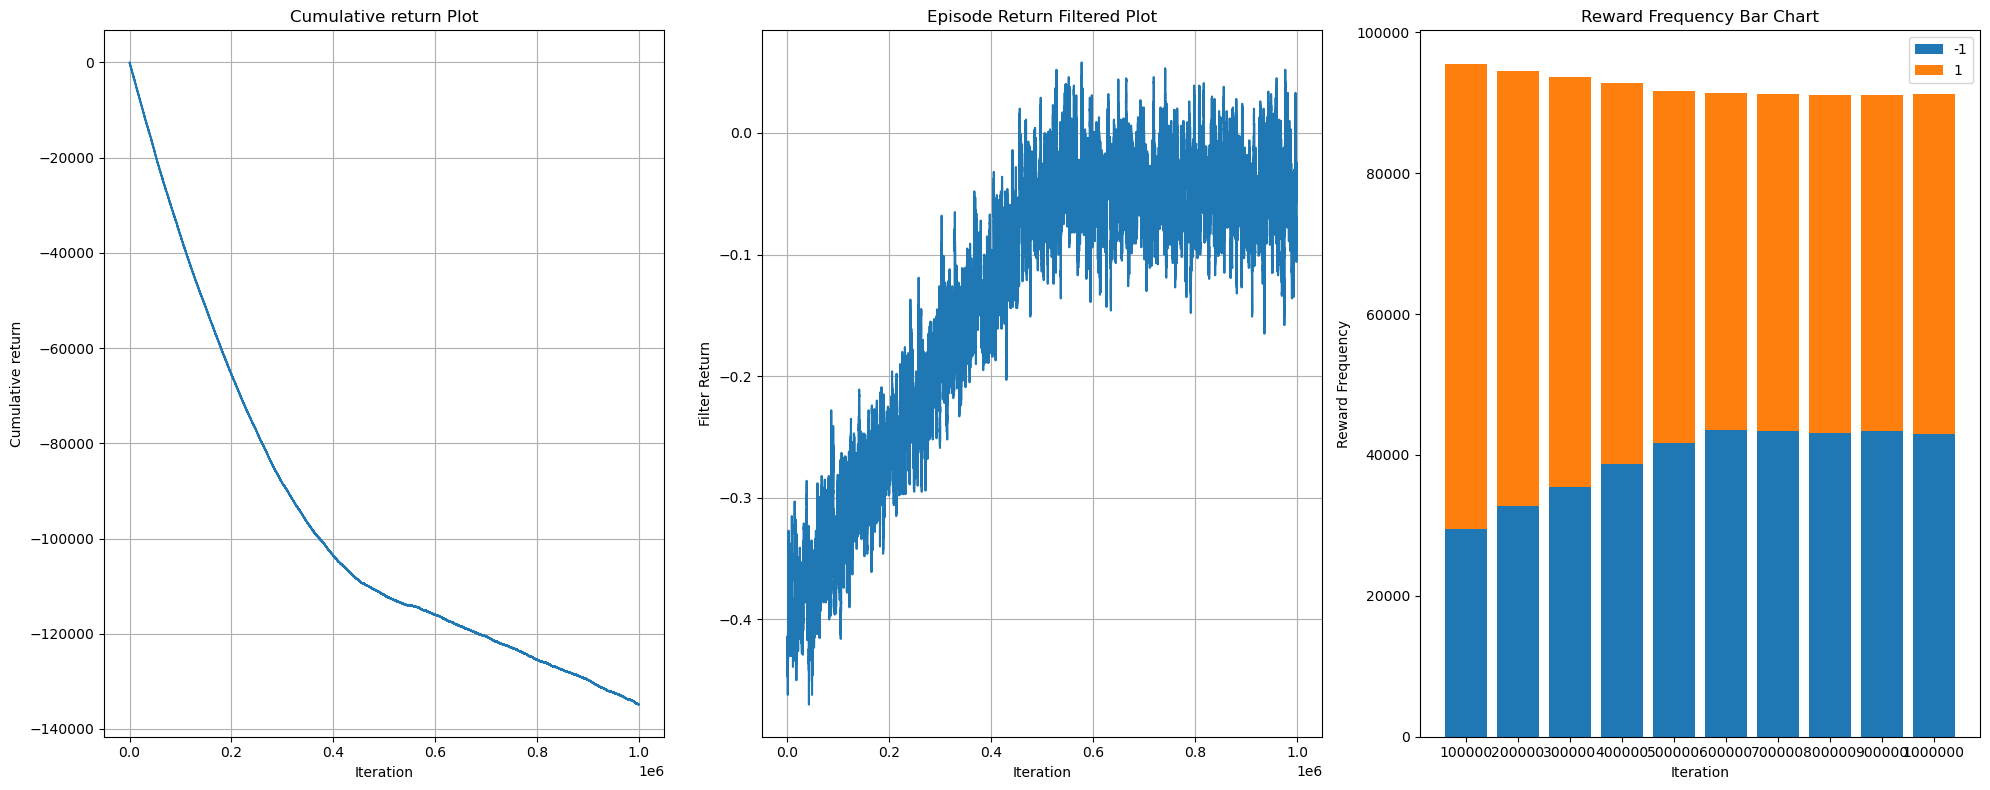

In [11]:
Training_Q_Learning_Culmulative_Return_np, Training_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Q-Learning iterations training

Load Agent

In [12]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.001
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(27, 8, 0): [0.0, 0.0],
             (20, 8, 0): [0.8792556301322229, -0.910391944327007],
             (20, 1, 0): [0.1439418576385476, -0.9367037101106398],
             (30, 5, 0): [0.0, 0.0],
             (20, 5, 0): [0.6626575382727574, -0.9429404838984092],
             (14, 10, 0): [-0.6050177245144237, -0.469148718593739],
             (13, 9, 0): [-0.4890308466453322, -0.444884010850555],
             (8, 5, 0): [-0.1905425317274675, 0.00010098408586700737],
             (16, 10, 0): [-0.5127845106106299, -0.7340625861538844],
             (30, 10, 0): [0.0, 0.0],
             (20, 10, 0): [0.3557222386580849, -0.928486384809621],
             (13, 3, 0): [-0.1808745475327808, -0.4645913257430315],
             (5, 3, 0): [-0.007857204800998876, -0.0015919490008359577],
             (21, 9, 0): [0.9448834506342954, -0.9938758804371552],
             (21, 9, 1): [0.9851290713325248, 0.001

In [13]:
#Testing Q-Learning 
env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

  0%|          | 455/100000 [00:00<00:21, 4540.53it/s]

100%|██████████| 100000/100000 [00:22<00:00, 4407.78it/s]


## Visualizing the testing with Q-Learning Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4309 negative:0.483
Iteration[10000:20000]     positive:0.4285 negative:0.4852
Iteration[20000:30000]     positive:0.4348 negative:0.4814
Iteration[30000:40000]     positive:0.4268 negative:0.492
Iteration[40000:50000]     positive:0.43 negative:0.4857
Iteration[50000:60000]     positive:0.4331 negative:0.4732
Iteration[60000:70000]     positive:0.4297 negative:0.4815
Iteration[70000:80000]     positive:0.4315 negative:0.4791
Iteration[80000:90000]     positive:0.4308 negative:0.4821
Iteration[90000:100000]     positive:0.4286 negative:0.4857

====================== Reward Frequency ======================


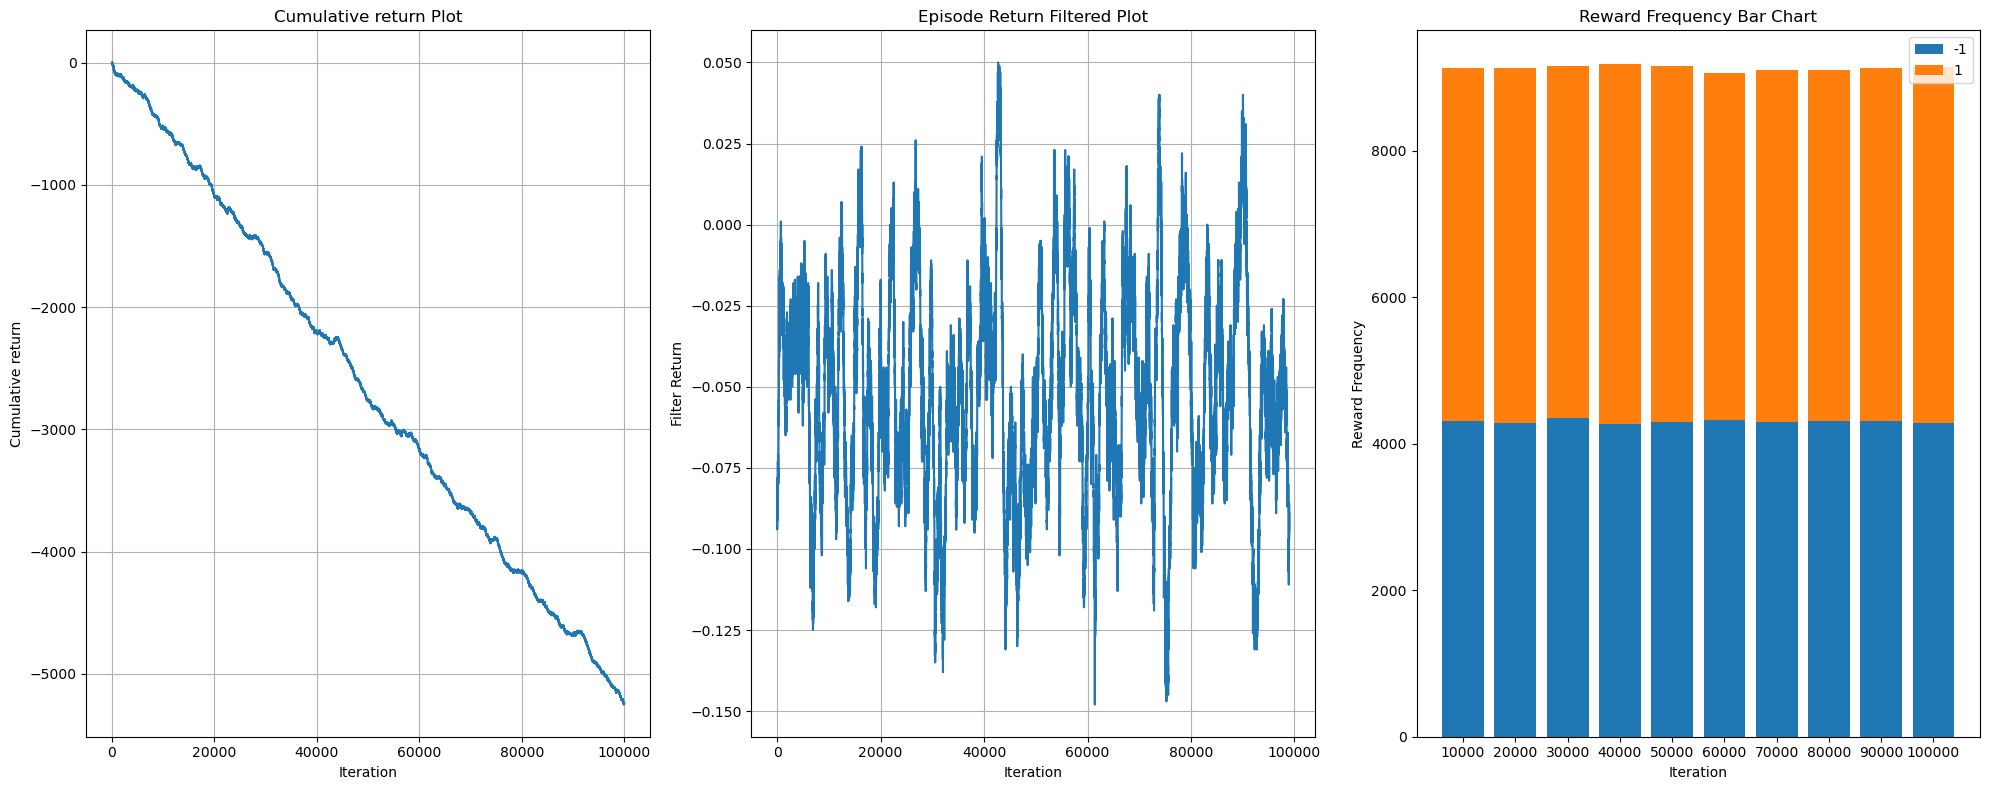

In [14]:
Testing_Q_Learning_Culmulative_Return_np, Testing_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




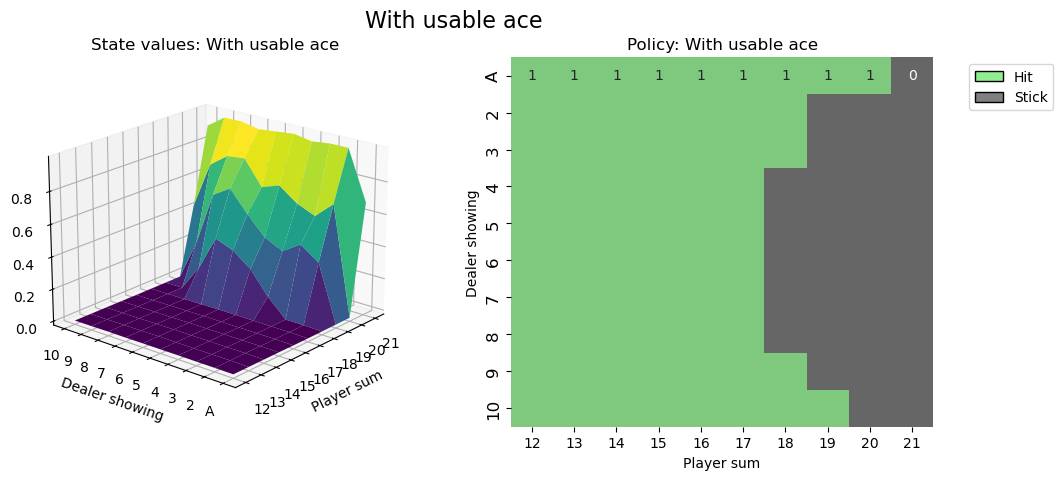

In [15]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

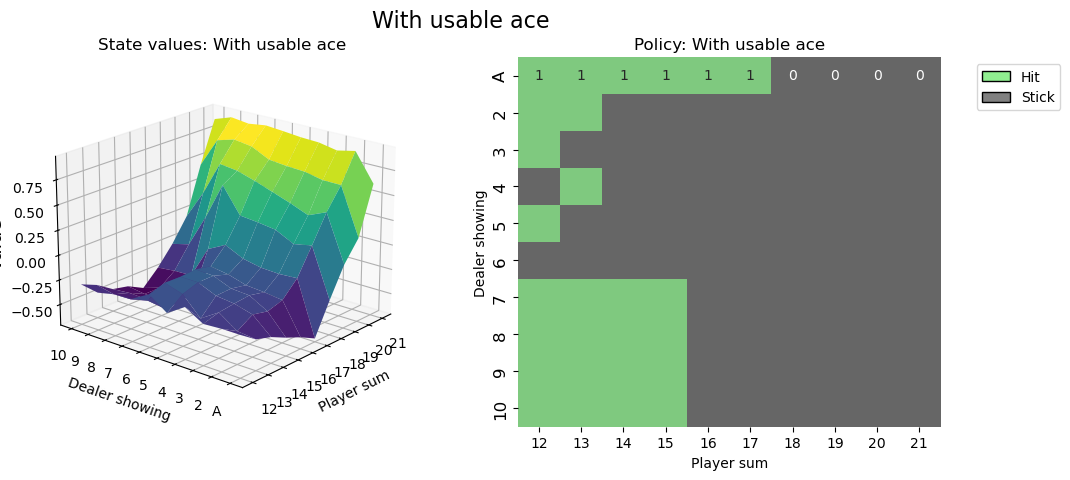

In [16]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# MC Control

## Parameters Studies for MC Algorithm

Discount 

100%|██████████| 10000/10000 [00:02<00:00, 4214.29it/s]


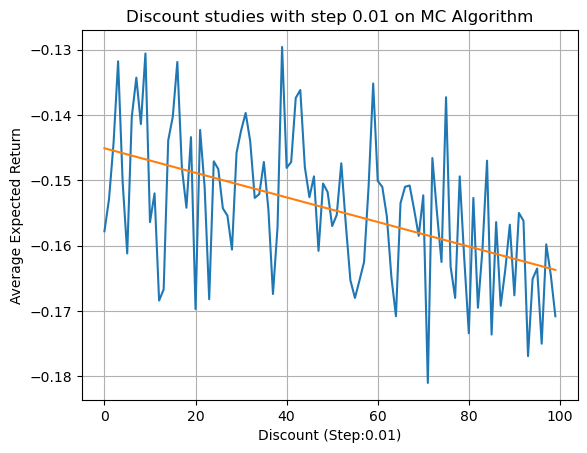

In [17]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on MC Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4897.23it/s]


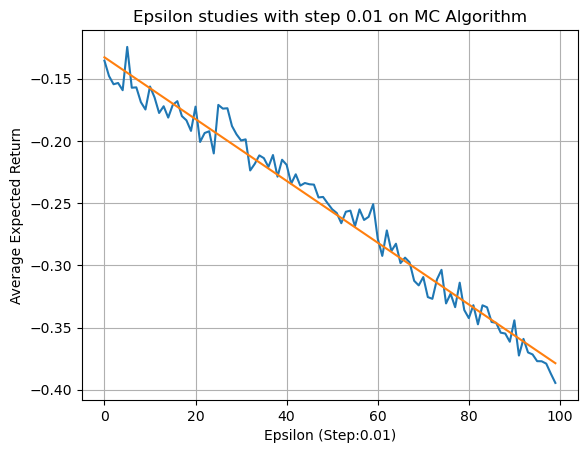

In [18]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,epsilon_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i

    discount = 0.01

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on MC Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [19]:
#Training MC

# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

Expected_Return = 0
count = 1

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())

100%|██████████| 1000000/1000000 [10:44<00:00, 1551.90it/s]


Save Agent

In [20]:
#Save MC agent
q_value_file = "monte_carlo.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with MC Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.3007 negative:0.6555
Iteration[100000:200000]     positive:0.32833 negative:0.61703
Iteration[200000:300000]     positive:0.35993 negative:0.57699
Iteration[300000:400000]     positive:0.39135 negative:0.53782
Iteration[400000:500000]     positive:0.42182 negative:0.49586
Iteration[500000:600000]     positive:0.43639 negative:0.48175
Iteration[600000:700000]     positive:0.43267 negative:0.48262
Iteration[700000:800000]     positive:0.43475 negative:0.48125
Iteration[800000:900000]     positive:0.43112 negative:0.4863
Iteration[900000:1000000]     positive:0.4328 negative:0.48264

====================== Reward Frequency ======================


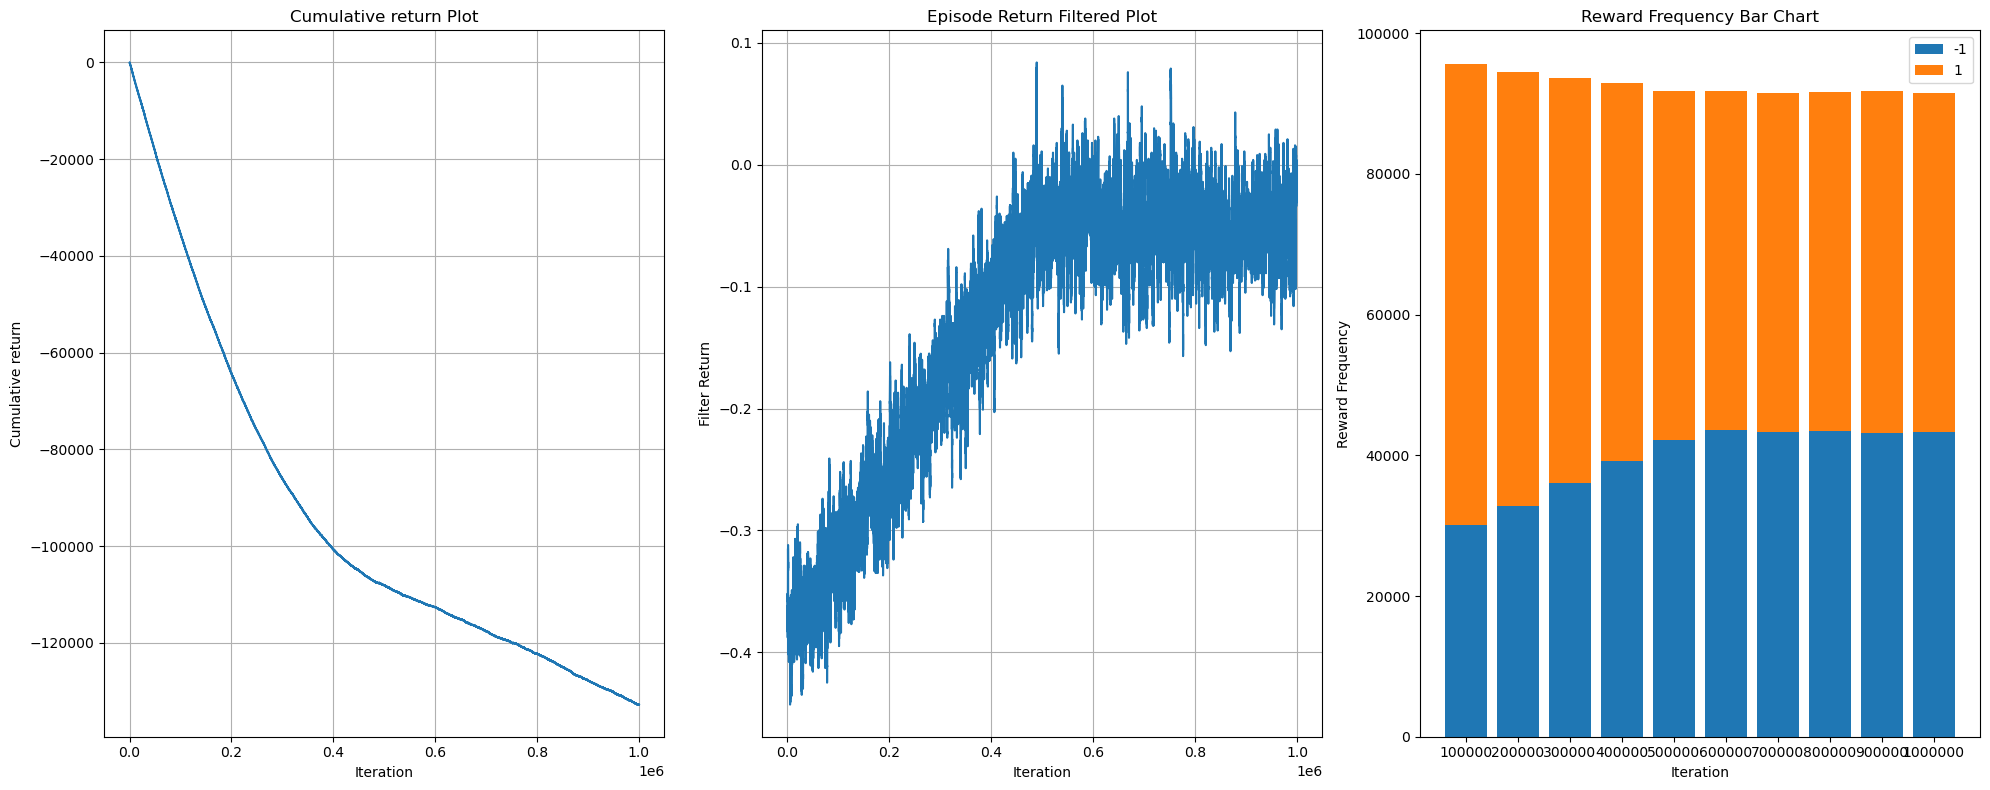

In [21]:
Training_MC_Culmulative_Return_np, Training_MC_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_MC_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_MC_reward_moving_average)

## Testing Algorithm Performance After 100000 iterations training

Load Agent

In [22]:
#Load MC Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "monte_carlo.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(19, 7, 0): [0.6291284034154987, -0.8433367415730336],
             (21, 5, 0): [0.8967861557478374, -1.0],
             (21, 5, 1): [0.9819552922165379, -0.000700896243291593],
             (20, 10, 0): [0.4360022940927074, -0.9228548241659142],
             (21, 2, 1): [0.9848094747682794, -0.0004219376257545272],
             (19, 10, 0): [-0.023372287145242098, -0.8515962135657862],
             (13, 10, 0): [-0.5851189074640927, -0.3829005955357637],
             (14, 8, 0): [-0.5294117647058831, -0.46470284078734286],
             (13, 7, 0): [-0.4207746478873236, -0.3840052205168561],
             (13, 1, 0): [-0.7477313974591654, -0.38465781356574463],
             (17, 9, 0): [-0.4210594989561583, -0.690898519249753],
             (17, 9, 1): [-0.40251572327044033, -0.0014741815748709093],
             (21, 6, 1): [0.9882168106834247, -7.542802303262959e-05],
             (20, 4, 0): [0.

In [23]:
# Testing MC

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()

    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

100%|██████████| 100000/100000 [00:22<00:00, 4357.58it/s]


## Visualizing the testing with MC Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4108 negative:0.5175
Iteration[10000:20000]     positive:0.402 negative:0.5216
Iteration[20000:30000]     positive:0.4173 negative:0.5072
Iteration[30000:40000]     positive:0.4039 negative:0.5233
Iteration[40000:50000]     positive:0.4077 negative:0.5236
Iteration[50000:60000]     positive:0.4122 negative:0.5093
Iteration[60000:70000]     positive:0.4093 negative:0.5154
Iteration[70000:80000]     positive:0.4141 negative:0.5073
Iteration[80000:90000]     positive:0.4105 negative:0.5125
Iteration[90000:100000]     positive:0.4166 negative:0.5079

====================== Reward Frequency ======================


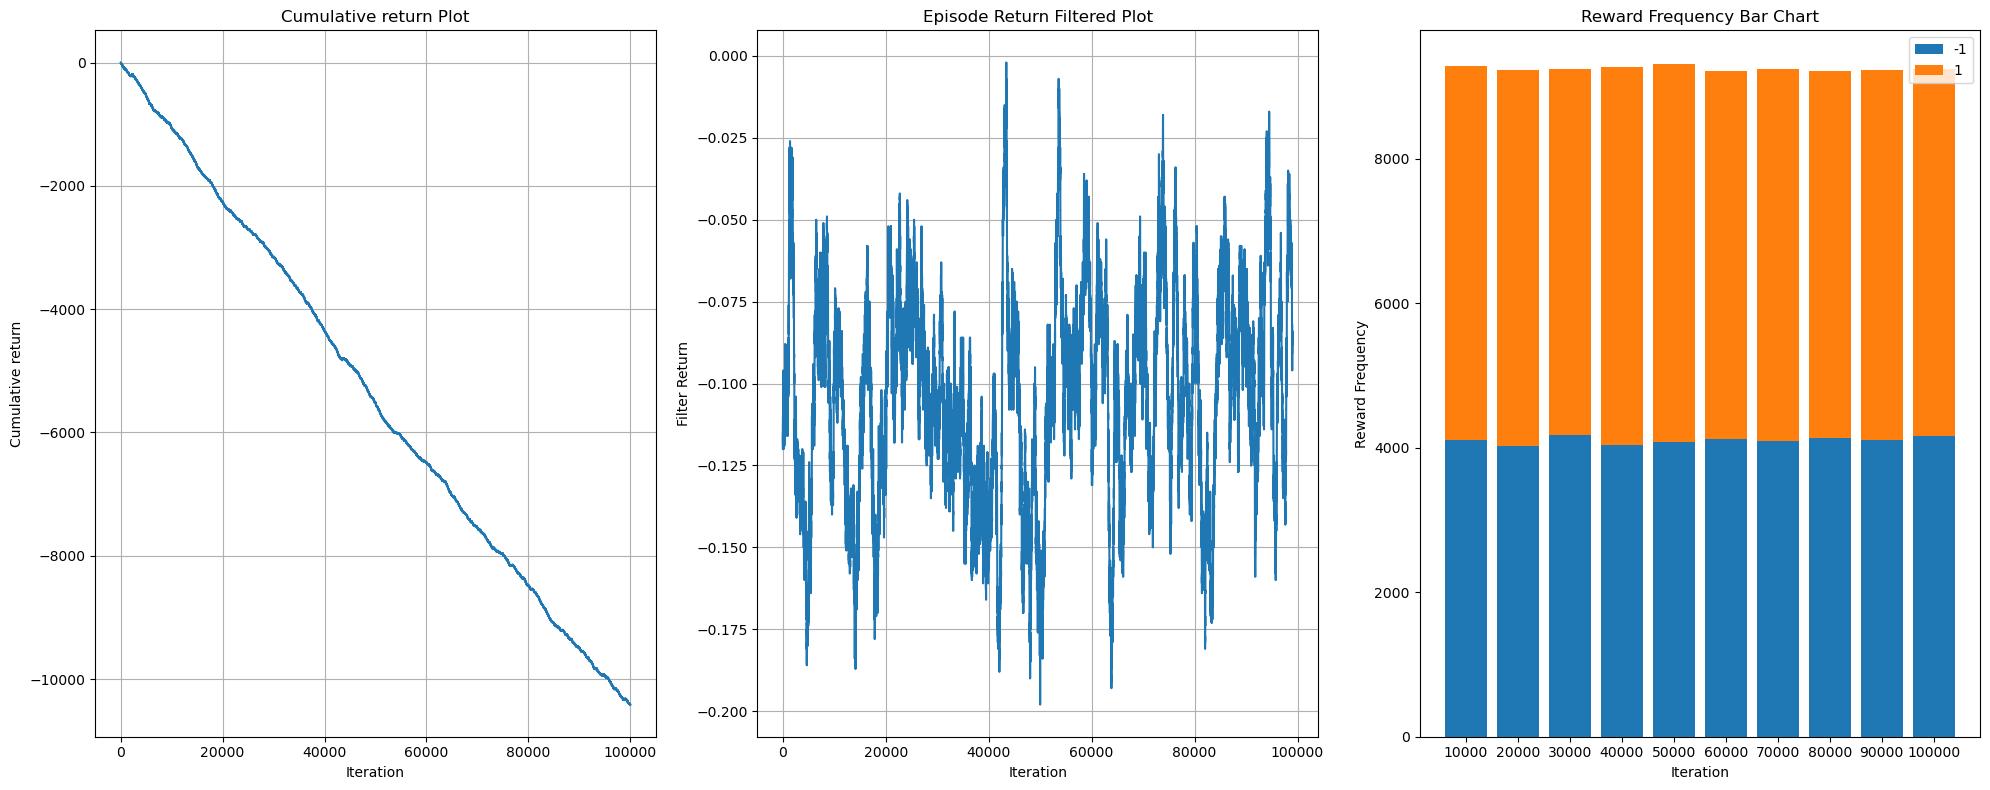

In [24]:
Testing_MC_Culmulative_Return_np, Testing_MC_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_MC_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_MC_reward_moving_average)

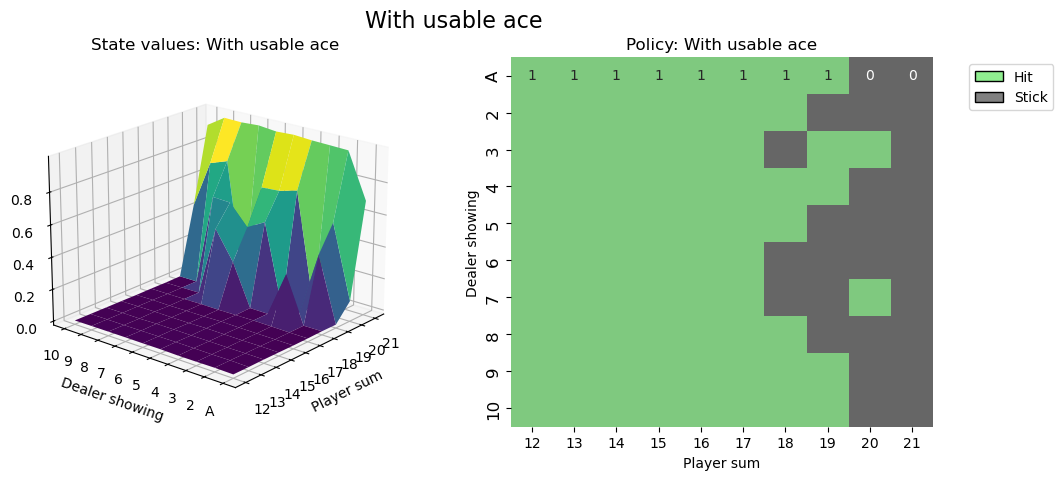

In [25]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

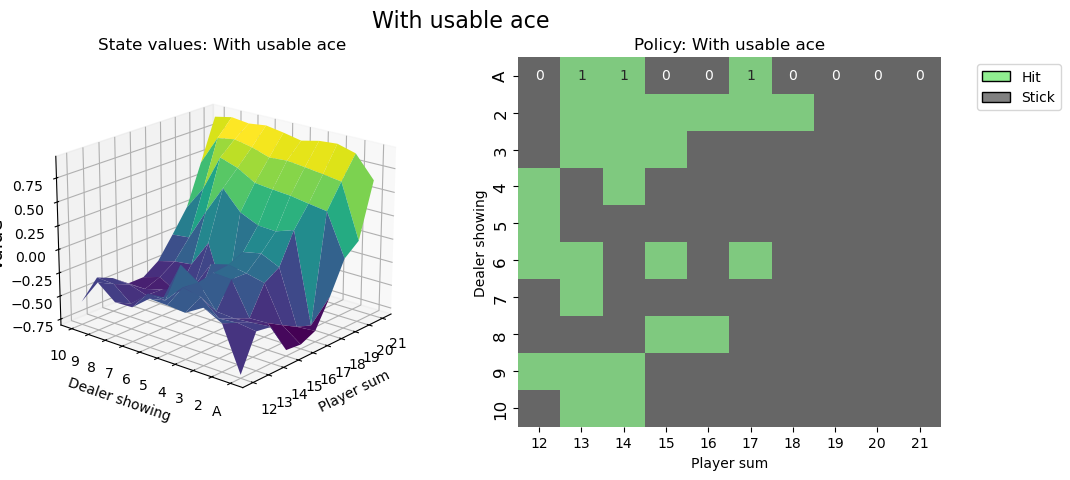

In [26]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

## TD Control

## Parameters Studies for SARSA Algorithm

Discount 

100%|██████████| 10000/10000 [00:01<00:00, 5027.86it/s]


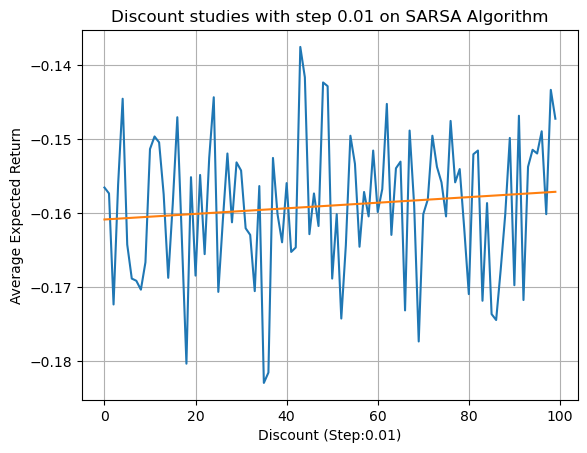

In [27]:
#Discount Hyper Paramter Studied

Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on SARSA Algorithm'.format(discount_step))
plt.grid(True)
plt.show()

Epsilon

100%|██████████| 10000/10000 [00:02<00:00, 4711.32it/s]


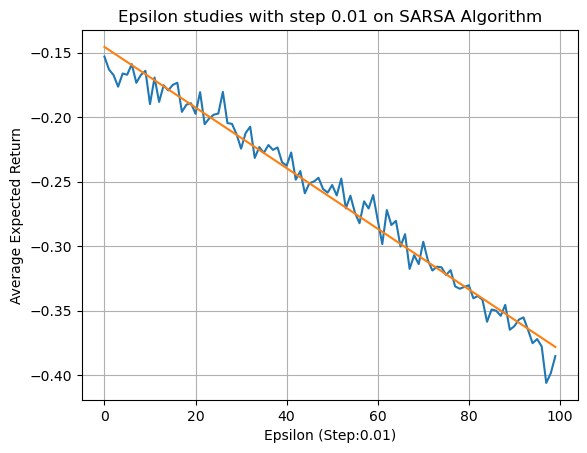

In [28]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on SARSA Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

  9%|▉         | 941/10000 [00:00<00:01, 4721.51it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4923.82it/s]


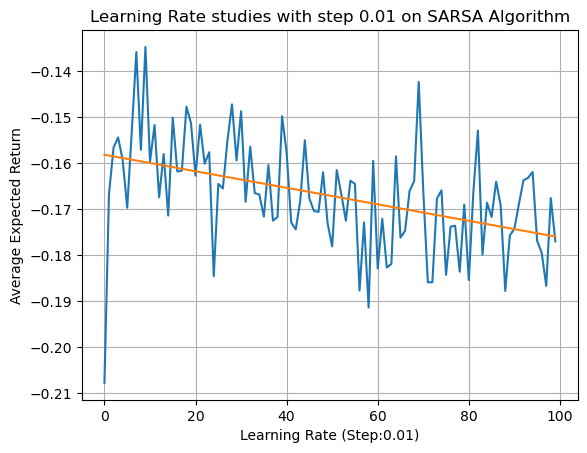

In [29]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,discount_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on SARSA Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [32]:
#Training SARSA
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 1.0

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        new_action = agent.get_action(next_obs)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = new_action

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [03:22<00:00, 4938.34it/s]


Save Agent

In [33]:
#Save SARSA agent
q_value_file = "temporal_difference.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with SARSA Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29855 negative:0.65533
Iteration[100000:200000]     positive:0.32931 negative:0.61803
Iteration[200000:300000]     positive:0.35742 negative:0.58025
Iteration[300000:400000]     positive:0.38545 negative:0.54372
Iteration[400000:500000]     positive:0.41614 negative:0.50086
Iteration[500000:600000]     positive:0.43141 negative:0.48179
Iteration[600000:700000]     positive:0.43227 negative:0.47908
Iteration[700000:800000]     positive:0.42915 negative:0.4797
Iteration[800000:900000]     positive:0.43036 negative:0.47805
Iteration[900000:1000000]     positive:0.43257 negative:0.47605

====================== Reward Frequency ======================


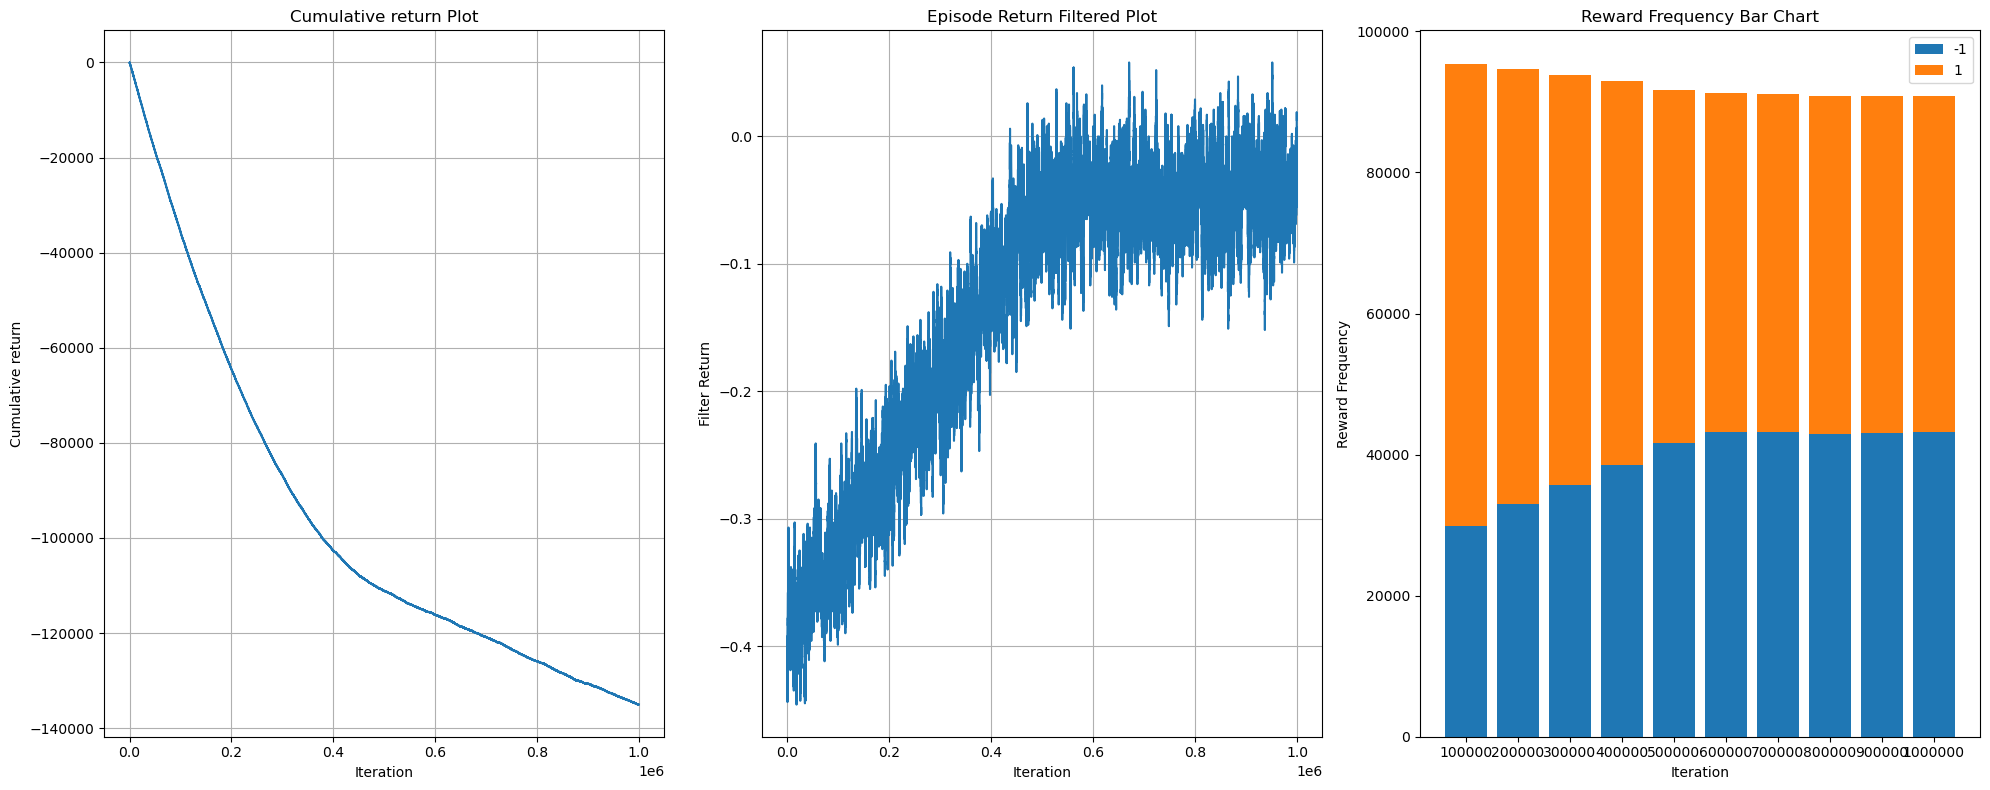

In [34]:
Training_SARSA_Culmulative_Return_np, Training_SARSA_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_SARSA_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_SARSA_reward_moving_average)

Load Agent

In [35]:
#Load SARSA Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "temporal_difference.json"
agent.load_model(full_path, q_value_file)

## Testing Algorithm Performance After 100000 iterations training

In [36]:
# Testing SARSA

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(next_obs)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            next_action=next_action,
            terminated=terminated
        )
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = new_action


100%|██████████| 100000/100000 [00:19<00:00, 5229.94it/s]


## Visualizing the testing with SARSA Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4136 negative:0.513
Iteration[10000:20000]     positive:0.4173 negative:0.5031
Iteration[20000:30000]     positive:0.4069 negative:0.5151
Iteration[30000:40000]     positive:0.4194 negative:0.5106
Iteration[40000:50000]     positive:0.4241 negative:0.4994
Iteration[50000:60000]     positive:0.4191 negative:0.5044
Iteration[60000:70000]     positive:0.4195 negative:0.5014
Iteration[70000:80000]     positive:0.4162 negative:0.5065
Iteration[80000:90000]     positive:0.419 negative:0.5048
Iteration[90000:100000]     positive:0.4243 negative:0.498

====================== Reward Frequency ======================


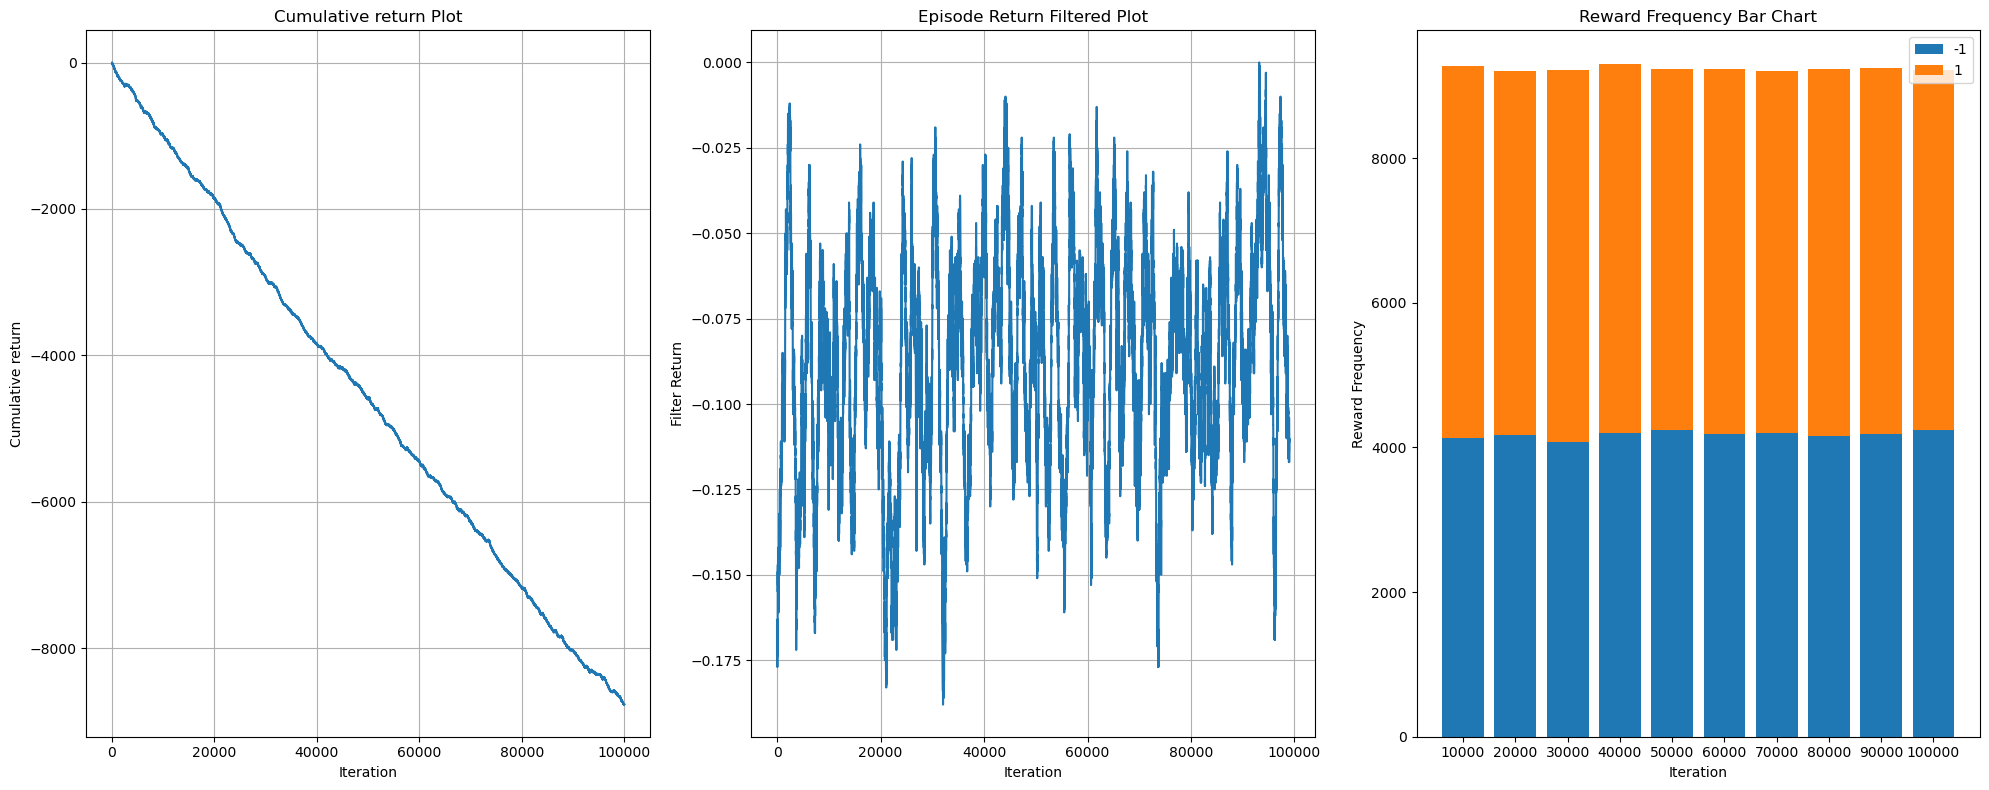

In [37]:
Testing_SARSA_Culmulative_Return_np, Testing_SARSA_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_SARSA_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_SARSA_reward_moving_average)

## Visualizing the training




## Visualising the policy



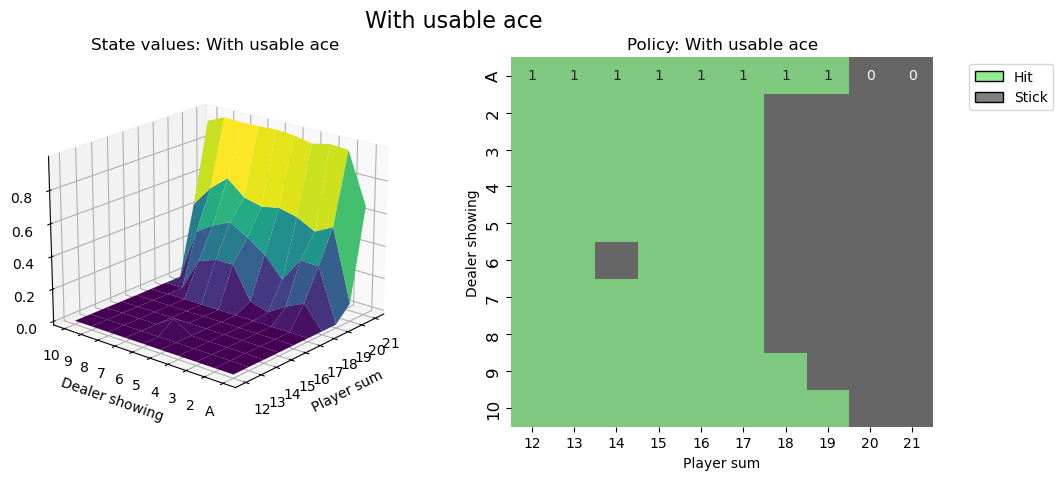

In [38]:
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

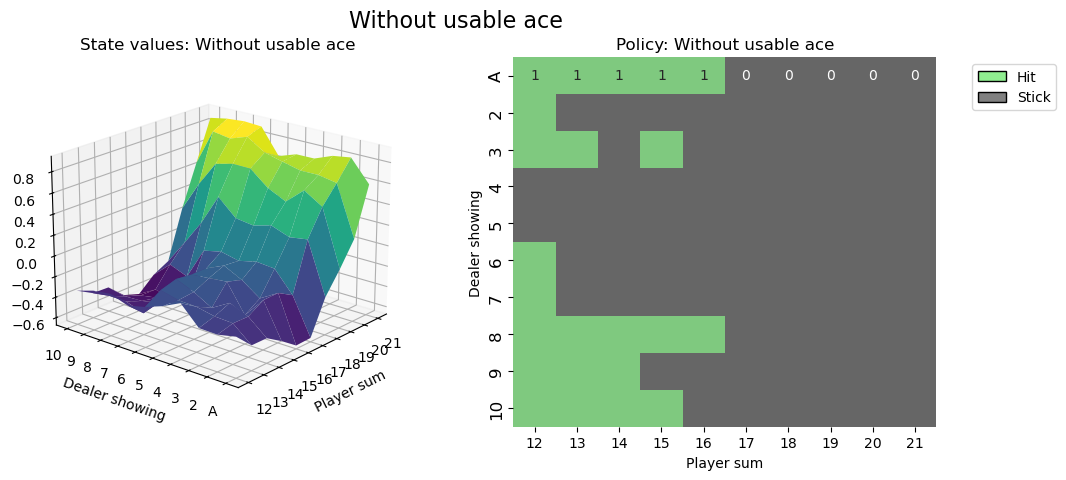

In [39]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

# Double Q-Learning Control

## Parameters Studies for Double Q-Learning Algorithm

Discount 

100%|██████████| 10000/10000 [00:01<00:00, 5182.67it/s]


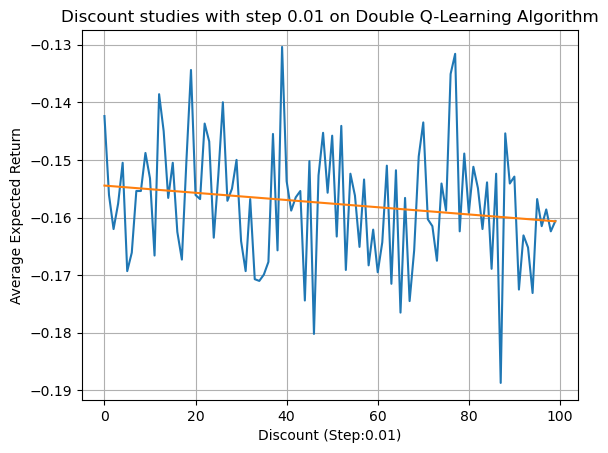

In [40]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Double Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

100%|██████████| 10000/10000 [00:01<00:00, 5032.34it/s]


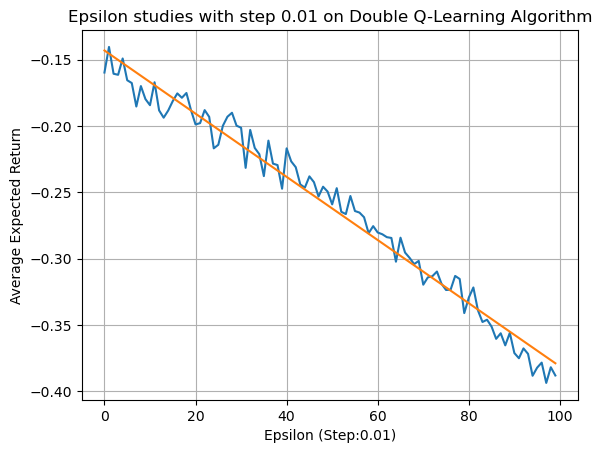

In [41]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,epsilon_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Double Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

100%|██████████| 10000/10000 [00:01<00:00, 5041.67it/s]


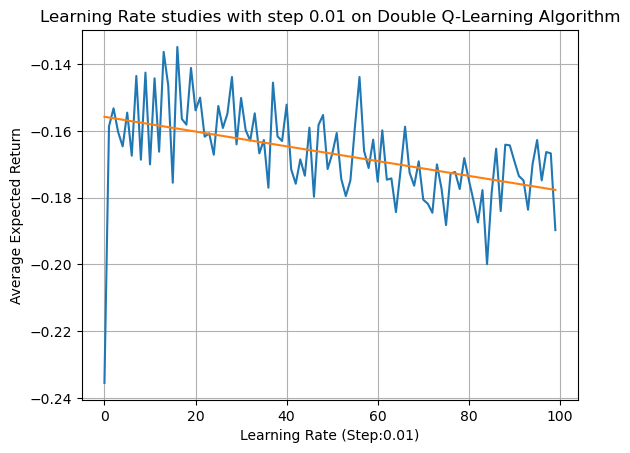

In [42]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,learning_rate_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Double Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [43]:
#Training Double Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 902/1000000 [00:00<03:42, 4491.99it/s]

100%|██████████| 1000000/1000000 [03:44<00:00, 4456.55it/s]


Save Agent

In [44]:
#Save Double Q-Learning agent
q_value_file = "double_q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Double Q-Learning Algorithm

====================== Reward Frequency ======================

Iteration[0:100000]     positive:0.29682 negative:0.65764
Iteration[100000:200000]     positive:0.32558 negative:0.61947
Iteration[200000:300000]     positive:0.35819 negative:0.57803
Iteration[300000:400000]     positive:0.38642 negative:0.54247
Iteration[400000:500000]     positive:0.41779 negative:0.49969
Iteration[500000:600000]     positive:0.42974 negative:0.48392
Iteration[600000:700000]     positive:0.43118 negative:0.48182
Iteration[700000:800000]     positive:0.42986 negative:0.48176
Iteration[800000:900000]     positive:0.42846 negative:0.48262
Iteration[900000:1000000]     positive:0.43335 negative:0.47682

====================== Reward Frequency ======================


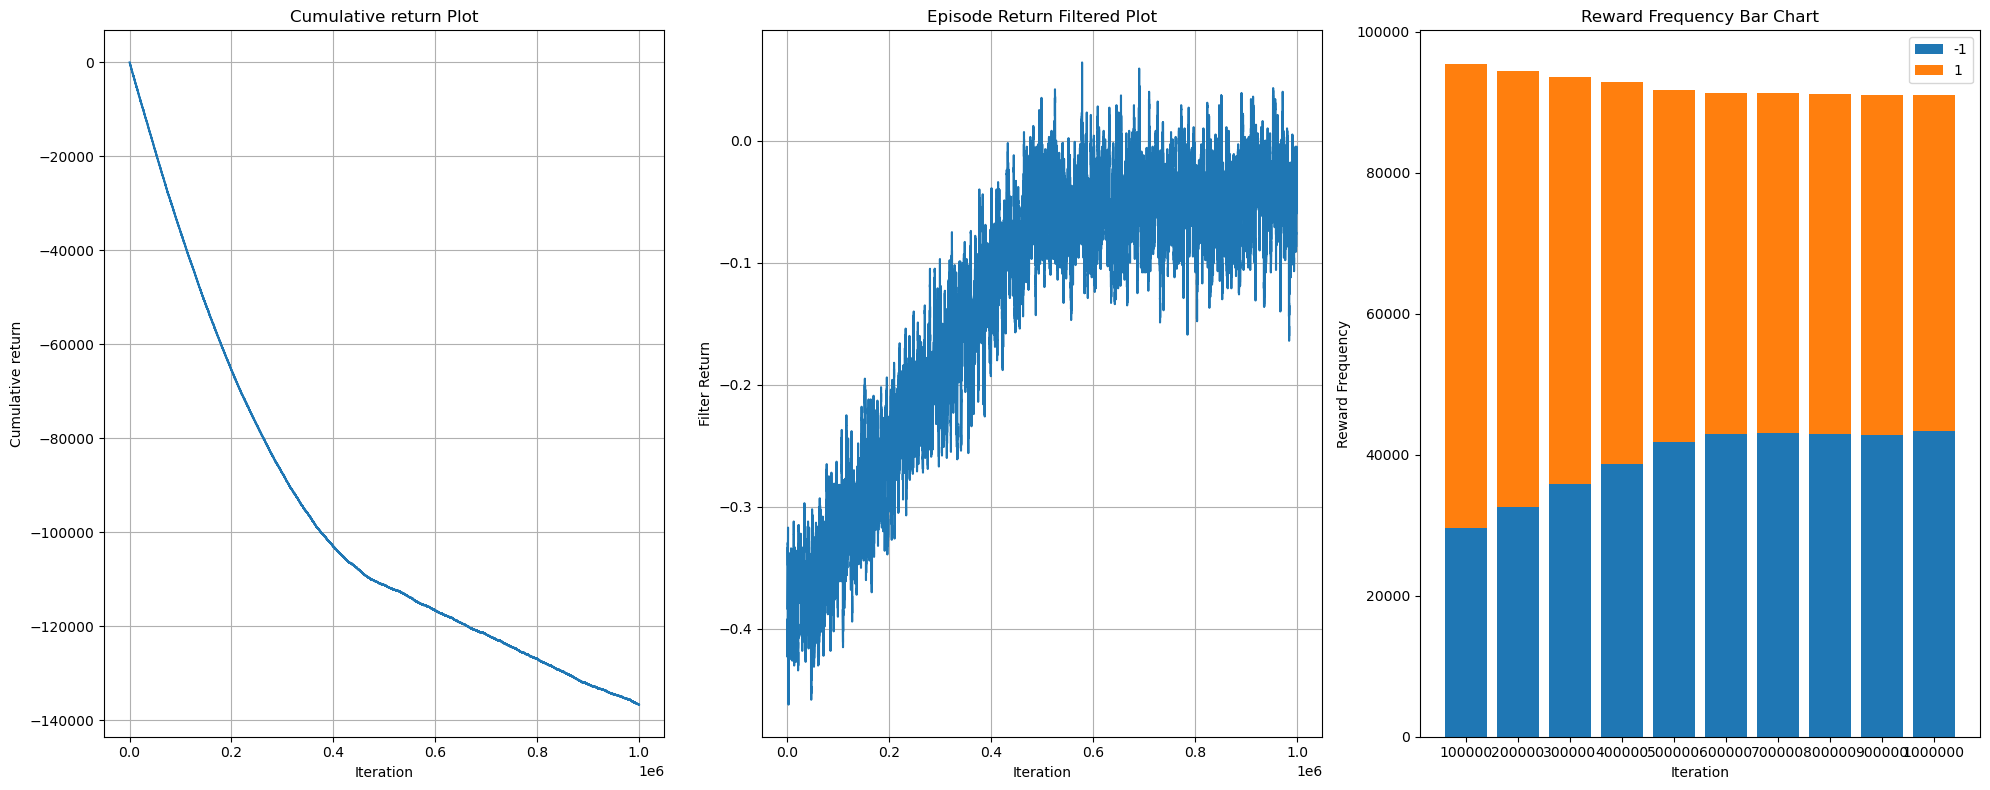

In [45]:
Training_Double_Q_Learning_Culmulative_Return_np, Training_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Double_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Double_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Double Q-Learning iterations training

Load Agent

In [46]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "double_q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(16, 2, 1): [-0.21691198799912104, -0.0008496187503629864],
             (16, 2, 0): [-0.6550778678257116, -1.1966486565848071],
             (16, 10, 1): [-0.9709075537632943, -0.004557246931959869],
             (17, 9, 0): [-0.9002981780541072, -1.3610939747456716],
             (9, 2, 0): [-0.6660931951143217, 0.0012693842301600643],
             (17, 10, 0): [-0.9636373243571055, -1.378484961435758],
             (12, 4, 0): [-0.40007269896585074, -0.701757847244032],
             (10, 1, 0): [-1.356104803555799, -0.0029868667847888445],
             (20, 1, 0): [0.32700630665433356, -1.8805450701646995],
             (18, 10, 0): [-0.45448689866725733, -1.5684332600506505],
             (17, 8, 1): [-0.441794247738871, -0.0017695016357478302],
             (18, 1, 0): [-0.7743052599183982, -1.5267922707115984],
             (13, 10, 0): [-1.2060358087171288, -0.8093651943556966],
          

In [47]:
#Testing Double Q-Learning
env = gym.make("Blackjack-v1", sab=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

100%|██████████| 100000/100000 [00:23<00:00, 4170.41it/s]


## Visualizing the testing with Double Q-Learning Algorithm




====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.4258 negative:0.4877
Iteration[10000:20000]     positive:0.4255 negative:0.4779
Iteration[20000:30000]     positive:0.4284 negative:0.4803
Iteration[30000:40000]     positive:0.4455 negative:0.4729
Iteration[40000:50000]     positive:0.4253 negative:0.4839
Iteration[50000:60000]     positive:0.4303 negative:0.4812
Iteration[60000:70000]     positive:0.4245 negative:0.4855
Iteration[70000:80000]     positive:0.4316 negative:0.4815
Iteration[80000:90000]     positive:0.4387 negative:0.478
Iteration[90000:100000]     positive:0.4296 negative:0.4817

====================== Reward Frequency ======================


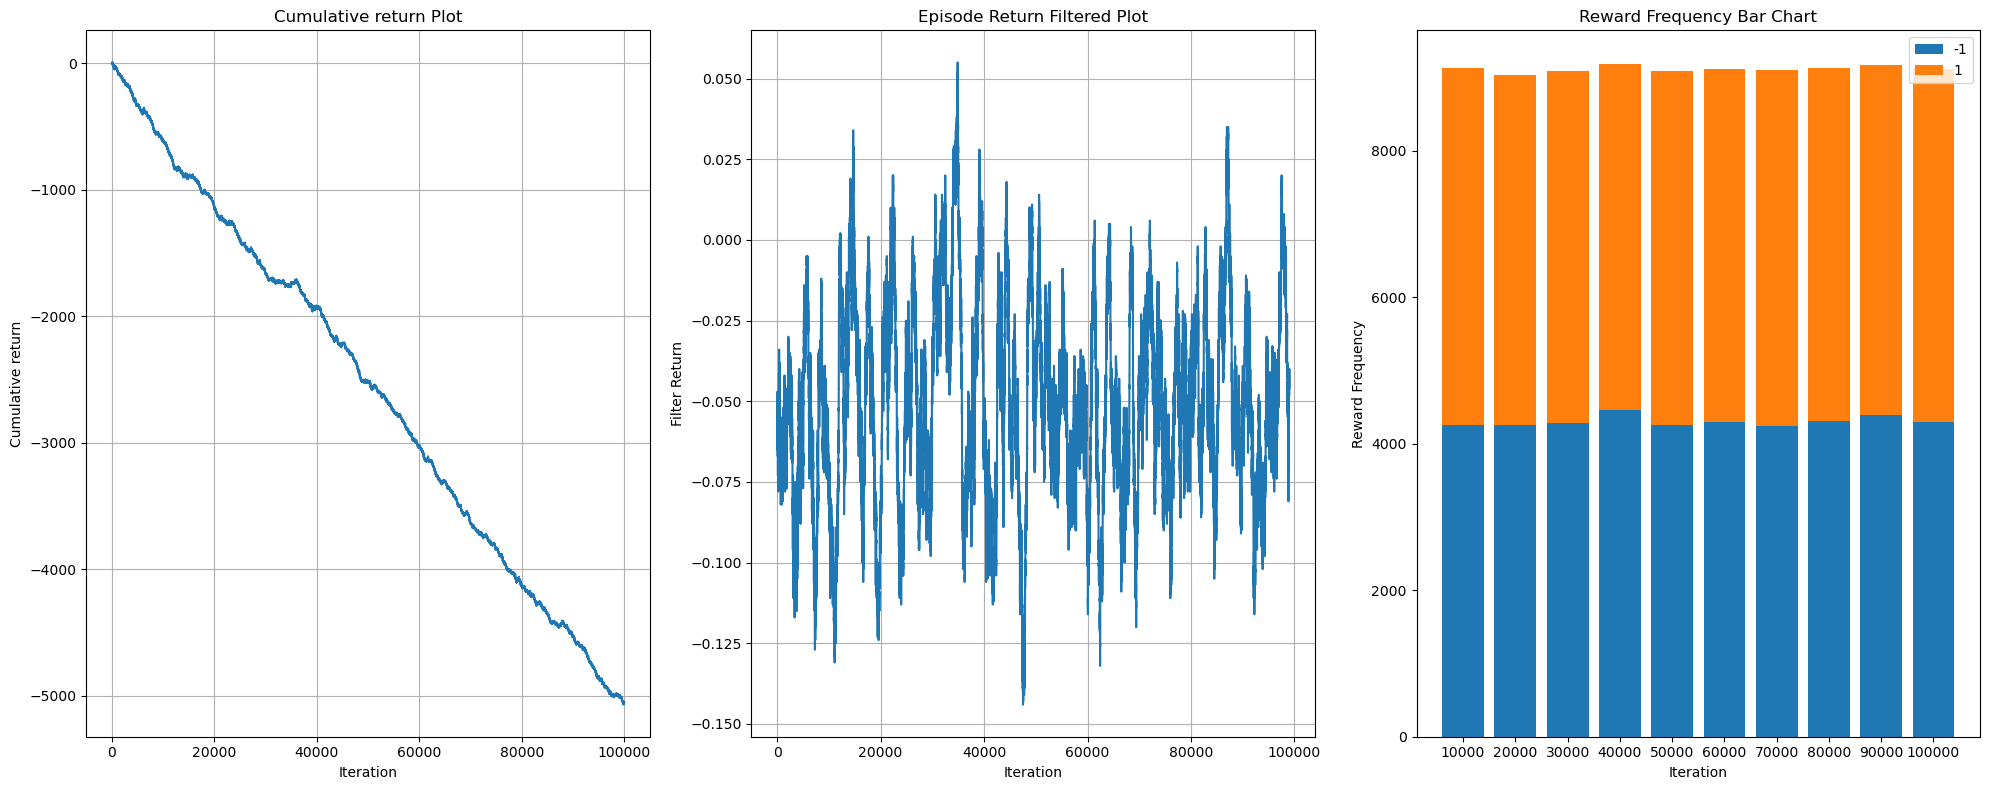

In [48]:
Testing_Double_Q_Learning_Culmulative_Return_np, Testing_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Double_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Double_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




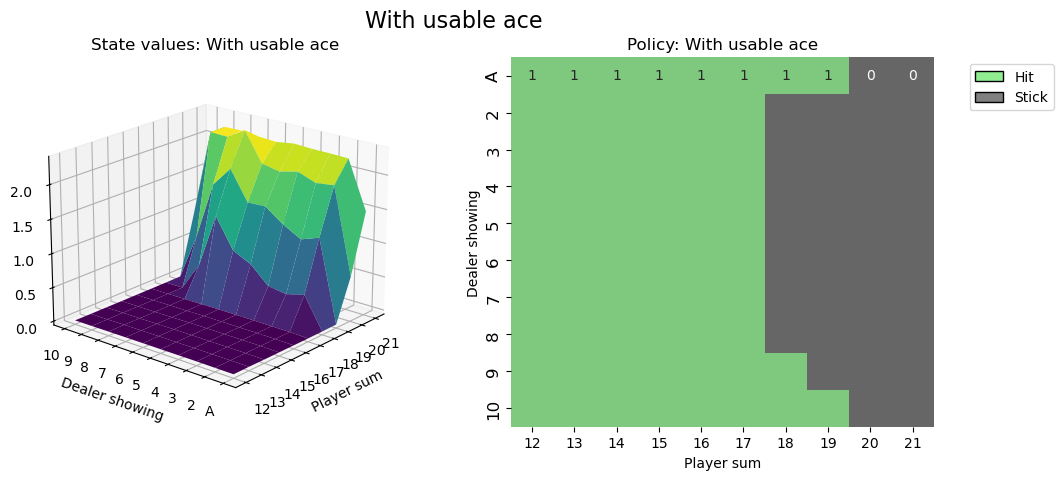

In [49]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

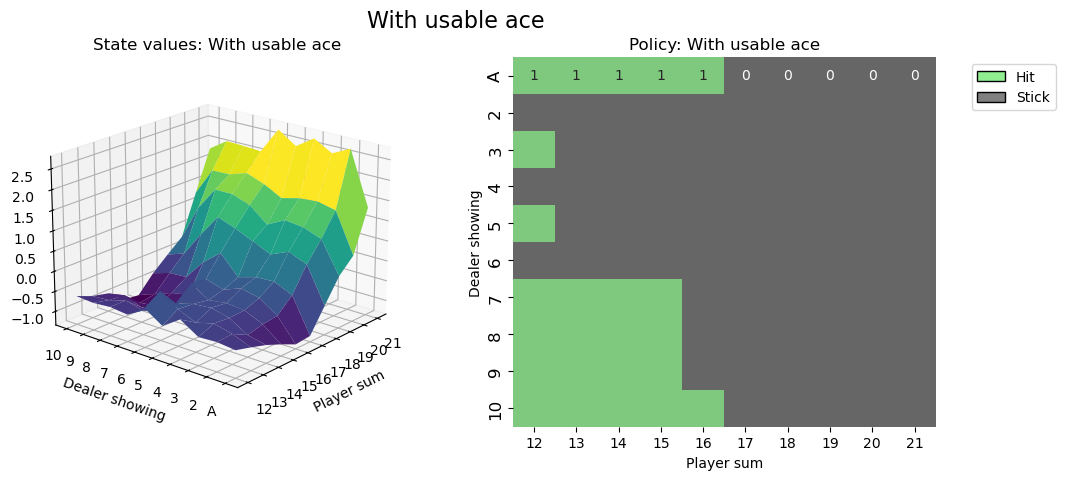

In [53]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Compare 4 algorithms (Q-Learning, MC, TD, Double Q-Learning) 

============= Expected Return =============
Q-Learning:  -0.134866
MC:  -0.13279
SARSA:  -0.135023
Double Q-Learning:  -0.136685
============= Expected Return =============


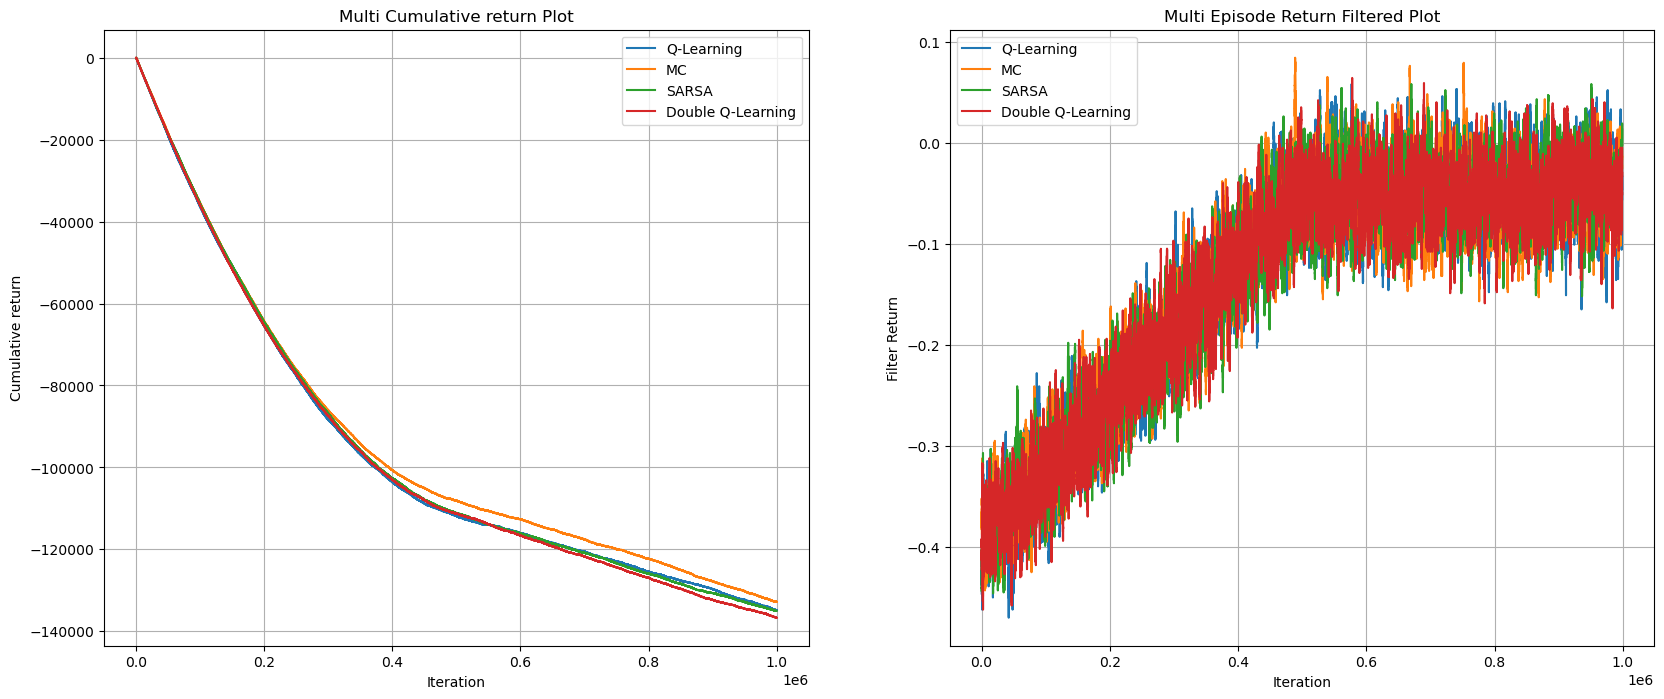

In [51]:
Reward_compare_plot(Training_Culmulative_Return_ls, Training_reward_moving_average_ls)

============= Expected Return =============
Q-Learning:  -0.05242
MC:  -0.10412
SARSA:  -0.08769
Double Q-Learning:  -0.05054
============= Expected Return =============


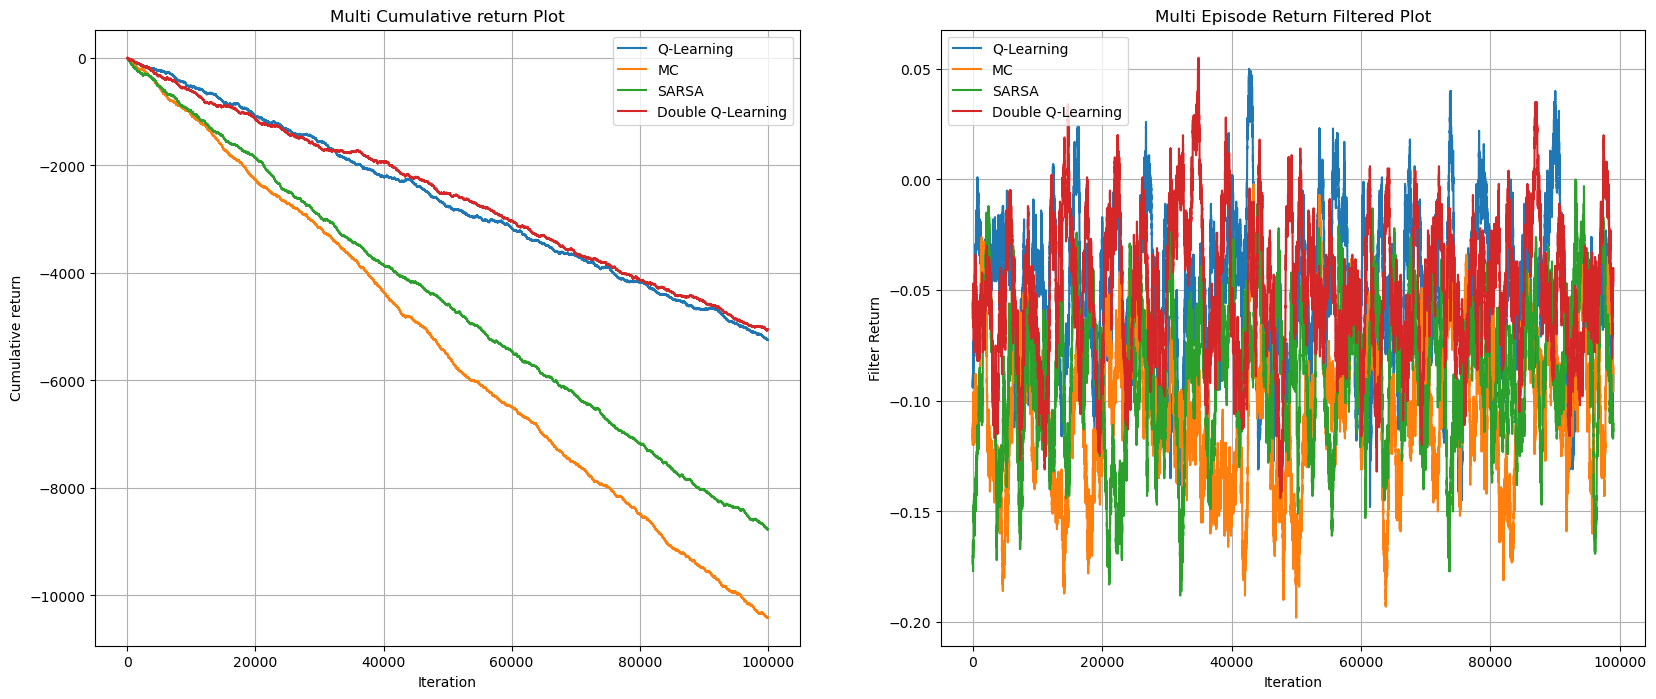

In [52]:
Reward_compare_plot(Testing_Culmulative_Return_ls, Testing_reward_moving_average_ls)